In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [15]:
class PopulationEvolution:
    def __init__(self, population_size = 100, top_k = 20, main_genotype_length = 1, meta_level = 3, meta_initialization = 0.1, meta_mutation_rate = 0.1, nr_of_generations = 2000, referential = False, elitism = True, value = 1, mutation_type = 2, verbose = False):        
        """
        Initialize the parameters.

        Parameters:
        -----------
        population_size : int, default=100
            The size of the population. Must be >=1.
        
        top_k : int, default=20
            The number of top individuals selected for reproduction. Must be >= 1 and <= population_size.

        main_genotype_length : int, default=1
            The length of the main part of the genotype (the part of the genome that does not contain meta-parameters), i.e., the part representing the solution.

        meta_level : int, default=3
            The number of metaparameters for the individuals from the population. Must be >= 0.

        meta_initialization : float, default=0.1
            Initialization value for the metaparameters. (All metaparameters are initialized to the same value.) Must be > 0.

        meta_mutation_rate : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu et al., 2023.

        nr_of_generations : int, default=2000
            The number of generations for the algorithm to run.

        referential : bool, default=False
            Whether or not to use the self-referential top meta-mutation rate. 

        elitism : bool, default=True
            If True, retains a certain number of top-performing individuals in each generation.

        value : float, default=0.5
            The value of the auctioned item. Should be positive.

        mutation_type: int, default=1
            The type of meta-mutation scheme used - regular (1) or additive (2).

        verbose: bool, default=False,
            Prints additional info (population members) every 100 generations.

        Raises:
        -------
        ValueError:
            If any of the input parameters do not meet the constraints mentioned above.

        """
        if population_size < 1:
            raise ValueError("Invalid population size, should be >=1")
        if (top_k < 1) or (top_k > population_size):
            raise ValueError("Invalid number of elites, should be >=1 and <= population size")
        if main_genotype_length < 1:
            raise ValueError("Invalid length of the main genotype, should be >=1")
        if meta_level < 0:
            raise ValueError("Invalid number of metaparameters for the population, should be >=0")
        if meta_mutation_rate <= 0:
            raise ValueError("Invalid meta_mutation_rate parameter, should be > 0 since it is used as a scale/std") 
        if meta_initialization <= 0:
            raise ValueError("Invalid value for the meta_initialization parameter, should be > 0 since it is used as a scale/std")
        if value <= 0:
            raise ValueError("Invalid value for the value of the auctioneed item, should be > 0")      
        if mutation_type not in [1,2]:
            raise ValueError("Invalid value for the mutation_type parameter, should be equal to 1 (regular meta-mutation rates) or 2 (additive meta-mutation rates)")          
        self.population_size = population_size
        self.top_k = top_k
        self.main_genotype_length = main_genotype_length
        self.meta_level = meta_level
        self.meta_initialization = meta_initialization
        self.meta_mutation_rate = meta_mutation_rate
        self.nr_of_generations = nr_of_generations
        self.referential = referential
        self.elitism = elitism
        self.value = value
        self.mutation_type = mutation_type
        self.t = 0 # time/current generation
        self.verbose = verbose
        self.population = self.initialize_population(self.meta_level)
        self.noises = np.random.normal(0,0.01,self.nr_of_generations+1)

    def initialize_population(self, metalevel):
        e1 = np.random.normal(0,self.meta_initialization,(self.main_genotype_length+metalevel,self.population_size)).T
        return e1

    def play(self, solution): 
        return abs(solution[0])
            
    def match(self, solution, time, value):
        '''
        Play a match. Returns tuple (payoff 1, payoff2, action1, action2)
        '''
        a1 = self.play(solution)
        if time < self.nr_of_generations/8:
            a2 = 40*time/self.nr_of_generations
        elif time < self.nr_of_generations/4:
            a2 = 0.8
        elif time < 3*self.nr_of_generations/8:
            a2 = 0.1
        elif time < self.nr_of_generations/2:
            a2 = 40*(self.nr_of_generations/2-time)/self.nr_of_generations
        elif time < 5*self.nr_of_generations/8:
            a2 = 0.8
        elif time < 3*self.nr_of_generations/4:
            a2 = 40*(time-5*self.nr_of_generations/8)/self.nr_of_generations
        elif time < 7*self.nr_of_generations/8:
            a2 = 0.8
        else:
            a2 = 40*(self.nr_of_generations-time)/self.nr_of_generations
        if a1 > a2:
            return value-a1, -a2, a1, a2
        elif a1 == a2:
            return value/2-a1, value/2-a2, a1, a2
        else:
            return -a1, value-a2, a1, a2

    def mutate(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(0, abs(solution[-1]))
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[i+1]))
                else:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[self.main_genotype_length]))
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                new_solution = solution + np.random.normal(0, abs(new_solution)) #check
        return new_solution
    
    def mutate_additive(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(abs(solution[-1]), mrate) #check
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(solution[i+1], mrate)
                else:
                    new_solution[i] = solution[i]+np.random.normal(solution[self.main_genotype_length],mrate)
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                new_solution = solution + np.random.normal(0, mrate+abs(new_solution)) #check
        return new_solution

    def evolve(self):
        mean_scores1, mean_scores2, std_scores1, std_scores2  = [], [], [], [] # mean scores, std scores
        mean_as1, mean_as2, std_as1, std_as2 = [], [], [], [] # mean actions
        mean_meta_1s, std_meta_1s, = [], [] #meta lowest meta-parameters
        mean_scores1_elite, std_scores1_elite, = [], [] # mean scores, std scores (elites)
        mean_as1_elite, std_as1_elite = [], [] # mean actions (elites)
        mean_meta_1s_elite, std_meta_1s_elite = [], [] #meta lowest meta-parameters (elites)
        for t in range(0, self.nr_of_generations+1):
            self.t = t
            scores1, scores2 = np.zeros((2,self.population_size))
            as1, as2 = np.zeros((2,self.population_size))
            # Evaluate
            for i, solution in enumerate(self.population):
                score1, score2, p1, p2 = self.match(solution, self.t, self.value)
                scores1[i] += score1
                scores2[i] += score2
                as1[i] += p1 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                as2[i] += p2 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
            mean_scores1.append(np.mean(scores1))
            mean_scores2.append(np.mean(scores2))
            std_scores1.append(np.std(scores1))
            std_scores2.append(np.std(scores2))
            mean_as1.append(np.mean(as1))
            mean_as2.append(np.mean(as2))
            std_as1.append(np.std(as1))
            std_as2.append(np.std(as2))
            top_indices = np.argsort(scores1)[-self.top_k:]
            mean_scores1_elite.append(np.mean(scores1[top_indices]))
            std_scores1_elite.append(np.std(scores1[top_indices]))
            mean_as1_elite.append(np.mean(as1[top_indices]))
            std_as1_elite.append(np.std(as1[top_indices]))
            if len(self.population[0]) > 1:
                mean_meta_1s.append(np.mean(self.population[:,1:],axis=0))
                std_meta_1s.append(np.std(self.population[:,1:],axis=0))
                mean_meta_1s_elite.append(np.mean(self.population[top_indices,1:],axis=0))
                std_meta_1s_elite.append(np.std(self.population[top_indices,1:],axis=0))
            else:
                mean_meta_1s.append(0)
                std_meta_1s.append(0)
                mean_meta_1s_elite.append(0)
                std_meta_1s_elite.append(0)
            #if self.t % 100 == 0:
                #print('Generation: {}'.format(t))
                #if self.verbose:
                  #  print("Top population members: ", self.population[top_indices])
            # Building the new populations
            new_population = []
            if self.elitism == True:
                for i in top_indices:
                    new_population.append(self.population[i])
            while len(new_population) < self.population_size:
                parent = copy.deepcopy(self.population[np.random.choice(top_indices)])
                if self.mutation_type == 1:
                    new_population.append(self.mutate(parent, self.meta_mutation_rate))
                else:
                    new_population.append(self.mutate_additive(parent, self.meta_mutation_rate))
            self.population = np.array(new_population)
        return np.array(mean_scores1), np.array(mean_scores2), np.array(std_scores1), np.array(std_scores2), np.array(mean_as1), np.array(mean_as2), np.array(std_as1), np.array(std_as2), np.array(mean_meta_1s), np.array(std_meta_1s), np.array(mean_scores1_elite), np.array(std_scores1_elite), np.array(mean_as1_elite), np.array(std_as1_elite), np.array(mean_meta_1s_elite), np.array(std_meta_1s_elite)

In [20]:
popevo = PopulationEvolution(
    population_size = 120, 
    top_k = 60, 
    main_genotype_length = 1, 
    meta_level = 1, 
    meta_initialization = 0.1, 
    meta_mutation_rate = 0.5, 
    nr_of_generations = 2000, 
    referential = False, 
    elitism = True, 
    value = 1, 
    mutation_type = 1, 
    verbose = False)
mean_scores1, mean_scores2, std_scores1, std_scores2, mean_as1, mean_as2, std_as1, std_as2, mean_meta_1s, std_meta_1s, mean_scores1_elite, std_scores1_elite, mean_as1_elite, std_as1_elite, mean_meta_1s_elite, std_meta_1s_elite = popevo.evolve()

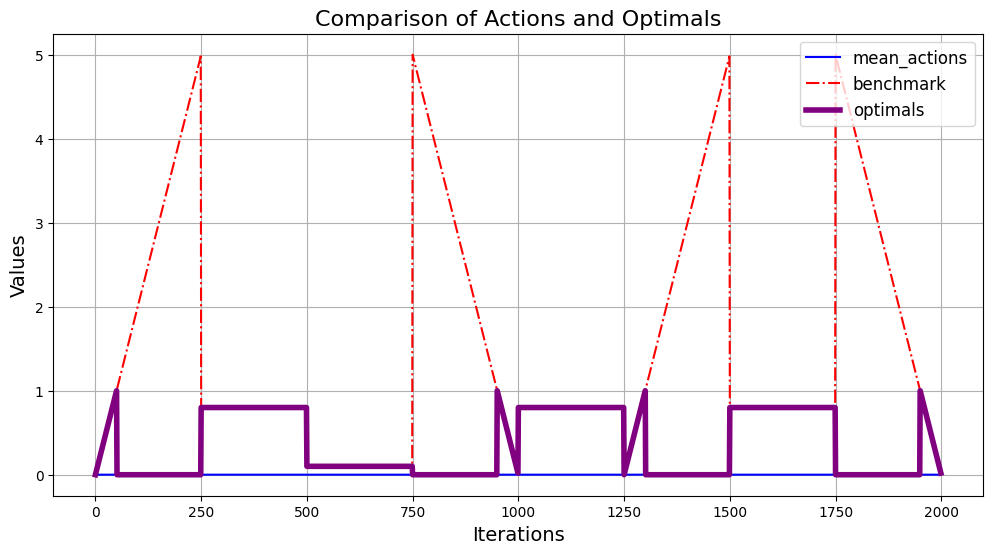

In [22]:
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot with adjusted line widths and styles
plt.plot(mean_as1[0:2000], label="mean_actions", linestyle='-', color='b')
#plt.plot(mean_as1_elite[0:2000], linewidth=4, label="mean_actions_elites", linestyle='--', color='g')
plt.plot(mean_as2[0:2000], label="benchmark", linestyle='-.', color='r')

# Modify the optimals
optimals = mean_as2[0:2000].copy()  # Avoid modifying the original array
optimals[optimals > popevo.value] = 0
plt.plot(optimals, label="optimals", linewidth=4, linestyle='-', color='purple')

# Add legend, grid, and labels
plt.legend(loc="upper right", fontsize=12)
plt.title("Comparison of Actions and Optimals", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.grid(True)

# Show the plot
plt.show()


In [23]:
for i in [0,1,2,3,4]:
    for j in [0.001,0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0]:
        popevo = PopulationEvolution(
            population_size = 100, 
            top_k = 50, 
            main_genotype_length = 1, 
            meta_level = i, 
            meta_initialization = 0.1, 
            meta_mutation_rate = j, 
            nr_of_generations = 2000, 
            referential = False, 
            elitism = True, 
            value = 1, 
            mutation_type = 1, 
            verbose = False)
        meta_mean_scores1 = []
        meta_mean_scores1_elite = []
        for k in range(10):
            mean_scores1, mean_scores2, std_scores1, std_scores2, mean_as1, mean_as2, std_as1, std_as2, mean_meta_1s, std_meta_1s, mean_scores1_elite, std_scores1_elite, mean_as1_elite, std_as1_elite, mean_meta_1s_elite, std_meta_1s_elite = popevo.evolve()
            meta_mean_scores1.append(np.mean(mean_scores1))
            meta_mean_scores1_elite.append(np.mean(mean_scores1_elite))
        print("meta_level: {}, mutation_rate: {}".format(i,j))
        print("Mean scores: {}, mean elite scores: {}".format(np.mean(meta_mean_scores1), np.mean(meta_mean_scores1_elite)))

KeyboardInterrupt: 